In [2]:
import pandas as pd
import numpy as np
import cv2
import re
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
project_path = 'Downloads/GTSRB/'

train_path = 'Downloads/GTSRB/Train/'
test_path = 'Downloads/GTSRB/Test/'

train_dataset_summary = pd.read_csv(project_path + 'Train.csv')
test_dataset_summary = pd.read_csv(project_path + 'Test.csv')

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

TRAIN DATA IMPORT AND VISUALIZATION

In [5]:
winSize = (40,40)
blockSize = (20,20)
blockStride = (10,10)
cellSize = (10,10)
nbins = 10

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

In [6]:
# import and reshape image
def get_import_image(link):
    return cv2.imread(link)

def resize_image(image, width=40, height=40):
    return cv2.resize(image, (width, height))


def transform_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def hog_image(image, hog):
    return hog.compute(image)


def get_image(link, hog, width=40, height=40):
    return hog_image(transform_to_gray(resize_image(get_import_image(link), width, height)), hog)

In [7]:
# importing training data 
images_train = []
responses_train = [] 
for class_ in classes.keys():
    for sample in os.listdir(train_path + str(class_) ):
        images_train.append(get_image(train_path + str(class_) + '/' + sample,hog))
        responses_train.append(class_)

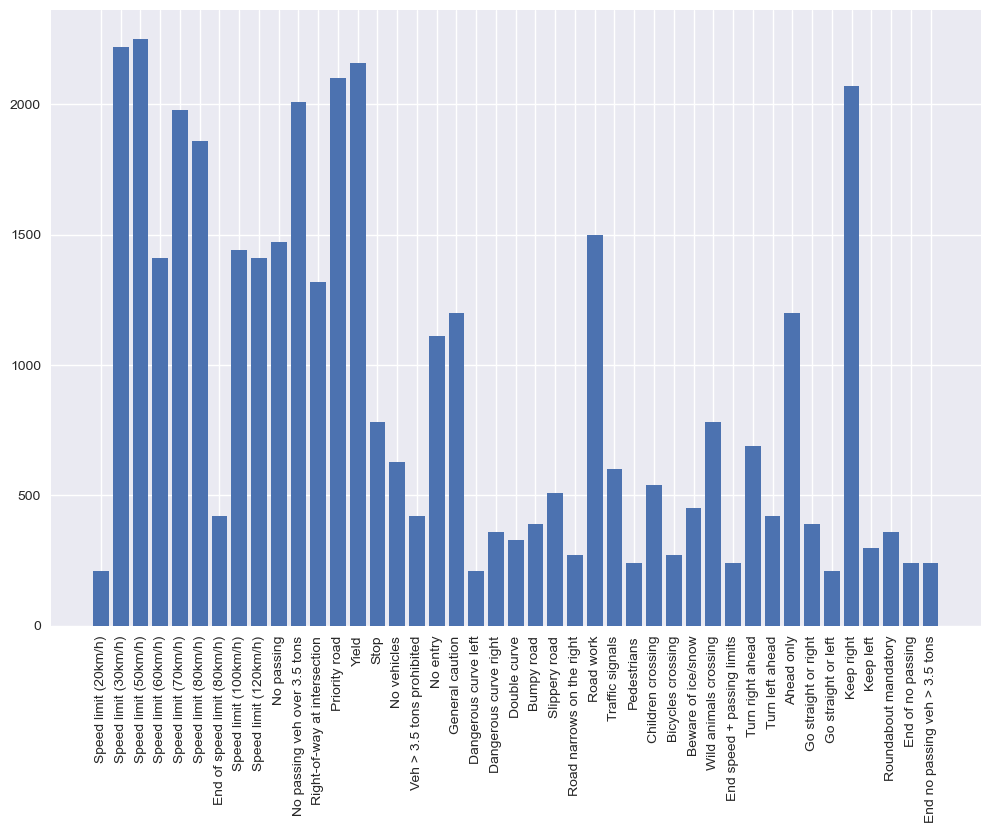

In [8]:
# calculating and visualizing frequency of classes

d={}
for class_ in classes.keys():
    d[classes[class_]] = responses_train.count(class_)

plt.figure(figsize=(12,8))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.show()

PREPARE TRAINING DATA

In [9]:
# reshaping x_train data to 2D
num_samples = np.array(images_train).shape[0]
x_train_reshaped = np.array(images_train).reshape(num_samples, -1)

shuffle_indexes = np.arange(x_train_reshaped.shape[0])
np.random.shuffle(shuffle_indexes)
x_train_reshaped = x_train_reshaped[shuffle_indexes]
responses_train = np.array(responses_train)[shuffle_indexes]

PREPARE TESTING DATA

In [10]:
test_dataset_summary['Path'] = test_dataset_summary['Path'].str.replace('Test/','')
test_dataset_summary = test_dataset_summary[['ClassId','Path']]

In [11]:
# importing training data 
images_test = []
responses_test = [] 
for index, row in test_dataset_summary.iterrows():
    images_test.append(get_image(test_path + row['Path'], hog))
    responses_test.append(row['ClassId'])

In [12]:
# reshaping x_test data to 2D
num_samples = np.array(images_test).shape[0]
x_test_reshaped = np.array(images_test).reshape(num_samples, -1)
responses_test = np.array(responses_test)

APPLYING MACHINE LEARNING

In [16]:
param_grid = {
    'C': [0.1,0.5,1,10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001]
}

In [17]:
svm_classifier = SVC()

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=3, verbose=2)

In [18]:
%%time
grid_search.fit(x_train_reshaped, responses_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.4min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.4min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.4min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 3.9min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.0min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.1min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.1min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 7.4min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 7.1min
[CV] END .....................C=0.1, gamma=1, k

In [19]:
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.991124424266555


In [20]:
# Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
# Best Score: 0.9220076404153819

In [21]:
y_pred = grid_search.predict(x_test_reshaped)

In [22]:
accuracy_score(responses_test,y_pred)

0.8849564528899446

In [23]:
# 0.8003958828186857

In [24]:
results = grid_search.cv_results_
print(results['mean_test_score'])

[0.93606062 0.86549016 0.98877804 0.05738478 0.93606062 0.78262642
 0.80356549 0.56563562 0.93606062 0.34642557 0.05738478 0.26430153
 0.93606062 0.10882706 0.05738478 0.05738478 0.97005787 0.97893336
 0.98890557 0.05738478 0.97005787 0.93345919 0.94340588 0.8455712
 0.97005787 0.6958097  0.05738478 0.54204405 0.97005787 0.26460758
 0.05738478 0.20755436 0.97505673 0.98834448 0.98890557 0.05738478
 0.97505673 0.96115688 0.9653651  0.89742153 0.97505673 0.80374402
 0.06365883 0.69726345 0.97505673 0.34780281 0.05738478 0.26493913
 0.97875487 0.99112442 0.98890557 0.07778827 0.97875487 0.98566653
 0.98755385 0.95705066 0.97875487 0.95850444 0.34555842 0.93570356
 0.97875487 0.80578436 0.05738478 0.69851315]
